<a href="https://colab.research.google.com/github/MananShukla7/SkimLit/blob/main/skimlit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Project : SkimLit📝🔥

`Short for Skimming Literature`

The purpose of this notebook is to build a NLP model to make reading medical abstracts
a lot easier

The Dataset that we are using is PubMed 200k RCT and the paper we are replicating is :
https://arxiv.org/abs/1710.06071



##Confirming access to GPU

In [1]:
!nvidia-smi

Tue Jun  6 17:52:34 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

##Getting Data

Downloading the dataset from the paper's author: https://github.com/Franck-Dernoncourt/pubmed-rct

In [2]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 5), reused 5 (delta 5), pack-reused 25
Unpacking objects: 100% (33/33), 177.08 MiB | 10.41 MiB/s, done.
Updating files: 100% (13/13), done.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [3]:
#Check what filer are in the PubMed 20k dataset
!ls /content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/

dev.txt  test.txt  train.txt


In [4]:
#Start our experiments by exploring and experimenting on 20k dataset!
data_dir="/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign"

In [5]:
#Check all of the filename of its directory
import os
filenames=[data_dir+"/"+filename for filename in os.listdir(data_dir)]
filenames

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt']

##Data Preprocessing

Now we've got some text data, now we have to explore it throughly.

To do that we need to visualise it first.

In [6]:
#Reading the files with python

def get_lines(filename):
  """
  Reads the filename (a text filename) and returns all of the lines of the text file
  as a list.

  Args:
  filname: a string containing the target filepath

  Returns:
  A list of string with one string per line from the input text line
  """
  f=open(filename,"r")
  return f.readlines()



In [7]:
# Let's read into the training lines
train_dir=filenames[1]
train_lines=get_lines(train_dir)
train_lines[:20]

['###24290286\n',
 'BACKGROUND\tIgE sensitization to Aspergillus fumigatus and a positive sputum fungal culture result are common in patients with refractory asthma .\n',
 'BACKGROUND\tIt is not clear whether these patients would benefit from antifungal treatment .\n',
 'OBJECTIVE\tWe sought to determine whether a @-month course of voriconazole improved asthma-related outcomes in patients with asthma who are IgE sensitized to A fumigatus .\n',
 'METHODS\tAsthmatic patients who were IgE sensitized to A fumigatus with a history of at least @ severe exacerbations in the previous @ months were treated for @ months with @ mg of voriconazole twice daily , followed by observation for @ months , in a double-blind , placebo-controlled , randomized design .\n',
 'METHODS\tPrimary outcomes were improvement in quality of life at the end of the treatment period and a reduction in the number of severe exacerbations over the @ months of the study .\n',
 'RESULTS\tSixty-five patients were randomized .

In [8]:
len(train_lines)

35212

###Data Structuring

Representing this data into dictionaries as it is easily manipulated.

A sample structure would look like:

```[{'line_number' : 0,
   'target' : 'BACKGROUND',
   'text' : 'Emotional eating is associated with overeating and the development of obesity .\n',
   'total_lines' : 11, 
   ...
   }]```

In [9]:
# def preprocess_text_with_line_num(filename):
#   types=["BACKGROUND", "OBJECTIVE", "METHODS", "RESULTS", "CONCLUSION"]
#   list1=[]
#   txtData=get_lines(filename)
#   linecount=0
#   for txt in txtData:
   
#     if txt.startswith("###"):
#         linecount=0
#         start_index=txtData.index(txt)
#         end_index=txtData.index("\n",start_index)
#         total_lines=end_index-start_index
#         # dict.update()
    
#     elif txt.isspace():

#       continue

#     else:

#       # for typ in types:
#       #   if typ in txt:
#       #     target=typ
#       target="abc"


#       start=txt.find("\t")
#       end=txt.find(".\n")
#       text=txt[start+1:end+1]
            
      
#       data={}
#       data["line_number"]=linecount
#       data["target"]=target
#       data["text"]=text
#       data["total_line"]=total_lines
#       # print(target.dtype)
#       list1.append(data)
#       linecount+=1
#       # print(f"[line_number:{linecount},\ntarget:{target},\ntext:{text},\ntotal_line:{total_lines}]\n\n")
#   return list1
  




  
    
    

In [10]:
def preprocess_text_with_line_numbers(filename):
  """Returns a list of dictionaries of abstract line data.

  Takes in filename, reads its contents and sorts through each line,
  extracting things like the target label, the text of the sentence,
  how many sentences are in the current abstract and what sentence number
  the target line is.

  Args:
      filename: a string of the target text file to read and extract line data
      from.

  Returns:
      A list of dictionaries each containing a line from an abstract,
      the lines label, the lines position in the abstract and the total number
      of lines in the abstract where the line is from. For example:

      [{"target": 'CONCLUSION',
        "text": The study couldn't have gone better, turns out people are kinder than you think",
        "line_number": 8,
        "total_lines": 8}]
  """
  input_lines = get_lines(filename) # get all lines from filename
  abstract_lines = "" # create an empty abstract
  abstract_samples = [] # create an empty list of abstracts
  
  # Loop through each line in target file
  for line in input_lines:
    if line.startswith("###"): # check to see if line is an ID line
      abstract_id = line
      abstract_lines = "" # reset abstract string
    elif line.isspace(): # check to see if line is a new line
      abstract_line_split = abstract_lines.splitlines() # split abstract into separate lines

      # Iterate through each line in abstract and count them at the same time
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {} # create empty dict to store data from line
        target_text_split = abstract_line.split("\t") # split target label from text
        line_data["target"] = target_text_split[0] # get target label
        line_data["text"] = target_text_split[1].lower() # get target text and lower it
        line_data["line_number"] = abstract_line_number # what number line does the line appear in the abstract?
        line_data["total_lines"] = len(abstract_line_split) - 1 # how many total lines are in the abstract? (start from 0)
        abstract_samples.append(line_data) # add line data to abstract samples list
    
    else: # if the above conditions aren't fulfilled, the line contains a labelled sentence
      abstract_lines += line
  
  return abstract_samples

In [11]:
filenames

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt']

In [12]:
%%time
train_samples=preprocess_text_with_line_numbers(filenames[1])
val_samples=preprocess_text_with_line_numbers(filenames[0])
test_samples=preprocess_text_with_line_numbers(filenames[2])


CPU times: user 562 ms, sys: 83.8 ms, total: 645 ms
Wall time: 769 ms


In [13]:
str1="###35279E"
x="###" in str1
x

True

In [14]:
l1=["BAKCGROUND","obj\n","\n"]
str2="BAKCGROUND \n ribdiuabda oddnaoid.\n"
for i in l1:
  print(i)
  if i in str2:
    x=i
s=str2.find("KC")
x,s

BAKCGROUND
obj





('\n', 2)

In [15]:
str2[0:2]

'BA'

In [16]:
l1.index("\n")

2

In [17]:
td="""Recreate the above func of greater efficiency """

##Data Analysis
Now that our data is in the format of dictionaries ,we can turn it into the df to
visualize it much better

In [18]:
import pandas as pd
train_df=pd.DataFrame(train_samples)
val_df=pd.DataFrame(val_samples)
test_df=pd.DataFrame(test_samples)
train_df.head(14)

,target,text,line_number,total_lines
0,BACKGROUND,ige sensitization to aspergillus fumigatus and...,0,9
1,BACKGROUND,it is not clear whether these patients would b...,1,9
2,OBJECTIVE,we sought to determine whether a @-month cours...,2,9
3,METHODS,asthmatic patients who were ige sensitized to ...,3,9
4,METHODS,primary outcomes were improvement in quality o...,4,9
5,RESULTS,sixty-five patients were randomized .,5,9
6,RESULTS,fifty-nine patients started treatment ( @ rece...,6,9
7,RESULTS,fifty-six patients took the full @ months of m...,7,9
8,RESULTS,"between the voriconazole and placebo groups , ...",8,9
9,CONCLUSIONS,we were unable to show a beneficial effect of ...,9,9


In [19]:
#DIstribution of labels in training labels
distrib=train_df.target.value_counts()
distrib


METHODS        9964
RESULTS        9841
CONCLUSIONS    4582
BACKGROUND     3449
OBJECTIVE      2376
Name: target, dtype: int64

<BarContainer object of 5 artists>

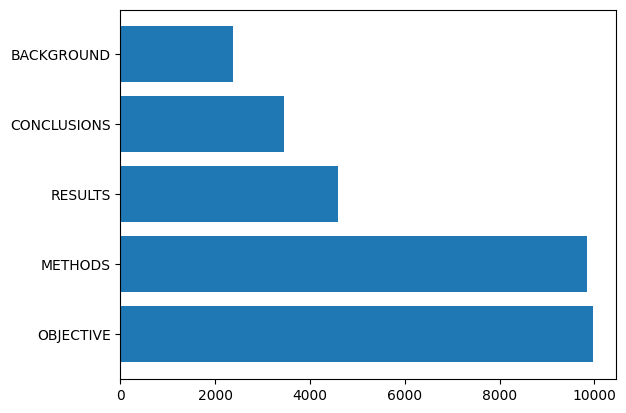

In [20]:
import matplotlib.pyplot as plt

plt.barh(val_df.target.unique(),distrib)

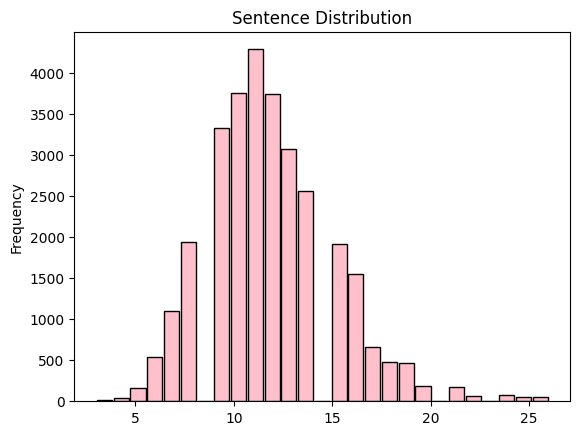

In [21]:
#Check length of different lines

# plt.bar(range(0,train_df.total_lines.value_counts().max()),train_df.total_lines.value_counts())
train_df.total_lines.plot(kind="hist",bins=27,rwidth=0.9,edgecolor="black",color="pink",xlabel="Number of sentences per abstract",title="Sentence Distribution");

In [22]:
(train_df.total_lines.value_counts())

11    4284
10    3751
12    3744
9     3330
13    3066
14    2565
8     1935
15    1920
16    1547
7     1096
17     666
6      539
18     475
19     460
20     189
21     176
5      162
24      75
22      69
26      54
25      52
4       45
3       12
Name: total_lines, dtype: int64

###Get the list of the sentences


In [23]:
#Convert abstract text into lists
train_sentences=train_df["text"].tolist()
val_sentences=val_df["text"].tolist()
test_sentences=test_df["text"].tolist()
len(train_sentences),len(val_sentences),len(test_sentences)

(30212, 180040, 30135)

In [24]:
train_labels=train_df["target"].tolist()
val_labels=val_df["target"].tolist()
test_labels=test_df["target"].tolist()
len(train_labels),len(val_labels),len(test_labels)

(30212, 180040, 30135)

In [25]:
#View the first 10 lines of the training sentences
train_sentences[:10],train_labels[:10]

(['ige sensitization to aspergillus fumigatus and a positive sputum fungal culture result are common in patients with refractory asthma .',
  'it is not clear whether these patients would benefit from antifungal treatment .',
  'we sought to determine whether a @-month course of voriconazole improved asthma-related outcomes in patients with asthma who are ige sensitized to a fumigatus .',
  'asthmatic patients who were ige sensitized to a fumigatus with a history of at least @ severe exacerbations in the previous @ months were treated for @ months with @ mg of voriconazole twice daily , followed by observation for @ months , in a double-blind , placebo-controlled , randomized design .',
  'primary outcomes were improvement in quality of life at the end of the treatment period and a reduction in the number of severe exacerbations over the @ months of the study .',
  'sixty-five patients were randomized .',
  'fifty-nine patients started treatment ( @ receiving voriconazole and @ receivi

##Making the numeric labels(for ml model)

###One hot encoder

In [26]:
# !pip install category_encoders -q
# import category_encoders as ce
# one_hot_encoded_lables=ce.OneHotEncoder(val_df.target.unique())


Using the get_dummies for now...

In [27]:
%%time
train_encoded_onehot=pd.get_dummies(train_df.target).to_numpy()
val_encoded_onehot=pd.get_dummies(val_df.target).to_numpy()
test_encoded_onehot=pd.get_dummies(test_df.target).to_numpy()

CPU times: user 35.1 ms, sys: 3.7 ms, total: 38.7 ms
Wall time: 55.3 ms


In [28]:
from sklearn.preprocessing import OneHotEncoder
encoder=OneHotEncoder(sparse=False)#tf doesnt support sparse matrix


In [29]:
%%time
train_one_hot=encoder.fit_transform(train_df["target"].to_numpy().reshape(-1,1))
train_one_hot

CPU times: user 12.9 ms, sys: 849 µs, total: 13.8 ms
Wall time: 22.9 ms


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

#####**Result**: get_dummies is a bit faster then one_hot(sklearn) [will see difference in the 200k dataset]

In [30]:
train_df.target[:5]

0    BACKGROUND
1    BACKGROUND
2     OBJECTIVE
3       METHODS
4       METHODS
Name: target, dtype: object

###Label encode labels



####Manual labelling

In [31]:
#Creating a Dictionary of target labels
target_labels={label:target for label,target in enumerate(val_df.target.unique())}
target_labels

{0: 'OBJECTIVE', 1: 'METHODS', 2: 'RESULTS', 3: 'CONCLUSIONS', 4: 'BACKGROUND'}

In [32]:
#get class names
class_names=val_df.target.unique()
class_names

array(['OBJECTIVE', 'METHODS', 'RESULTS', 'CONCLUSIONS', 'BACKGROUND'],
      dtype=object)

In [33]:
test=train_df.replace(train_df.target.unique(),range(0,len(train_df.target.unique())))
test[:5]

,target,text,line_number,total_lines
0,0,ige sensitization to aspergillus fumigatus and...,0,9
1,0,it is not clear whether these patients would b...,1,9
2,1,we sought to determine whether a @-month cours...,2,9
3,2,asthmatic patients who were ige sensitized to ...,3,9
4,2,primary outcomes were improvement in quality o...,4,9


####Using Sklearn here

In [34]:
from sklearn.preprocessing import LabelEncoder
label_encoder=LabelEncoder()
train_labels_encoded=label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded=label_encoder.transform(val_df["target"].to_numpy())
test_labels_encoded=label_encoder.transform(test_df["target"].to_numpy())

#check what the training label look like

train_labels_encoded[:5],train_labels_encoded.shape

(array([0, 0, 3, 2, 2]), (30212,))

In [35]:
class_names[train_labels_encoded[:5]]

array(['OBJECTIVE', 'OBJECTIVE', 'CONCLUSIONS', 'RESULTS', 'RESULTS'],
      dtype=object)

###Model 0(Bayes Classification): The baseline

In [36]:
#importing libraries
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

In [37]:
tf_vectorizer=CountVectorizer()
vectorized_sentences=tf_vectorizer.fit_transform(train_sentences)
vectorized_val_sentences=tf_vectorizer.transform(val_sentences)

In [38]:
len(train_sentences),vectorized_sentences.data

(30212, array([1, 1, 1, ..., 1, 1, 1]))

In [39]:
vectorized_val_sentences.shape,vectorized_sentences.shape

((180040, 20453), (30212, 20453))

In [40]:
nb_classifier=MultinomialNB()
nb_classifier.fit(vectorized_sentences,train_labels_encoded)

MultinomialNB()

In [41]:
nb_classifier.score(vectorized_val_sentences,val_labels_encoded)

0.7482337258387025

In [42]:
model_0_preds=nb_classifier.predict(vectorized_val_sentences)
model_0_preds[:5]

array([3, 2, 4, 2, 2])

In [43]:
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
cm=confusion_matrix(val_labels_encoded,model_0_preds)
cm

array([[11769,  4762,  1681,  3165,   350],
       [ 2667, 18360,  1069,   612,  4460],
       [ 1317,  1050, 50990,   640,  5356],
       [ 3410,  1944,  1598,  6688,   199],
       [  472,  2908,  7470,   198, 46905]])

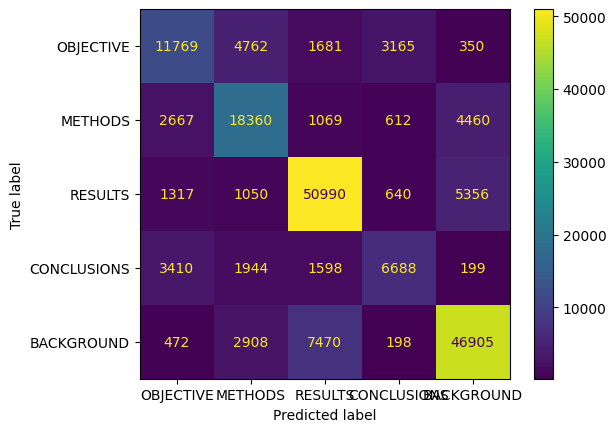

In [44]:
cm_display =ConfusionMatrixDisplay(confusion_matrix = cm,display_labels=class_names)

cm_display.plot();


In [45]:
from sklearn.metrics import accuracy_score,precision_recall_fscore_support
def calc_results(y_true,y_pred):
  """
  Calculates model accuracy, precision, recall and f1 score of a binary
  classification model.
  """

  #Classification model accuracy
  model_accuracy=accuracy_score(y_true,y_pred)*100
  #Calc the model precision recall and f1 score 
  model_precision,model_recall,model_f1score, _ =precision_recall_fscore_support(y_true,y_pred,average="weighted")
  return {"accuracy":model_accuracy,
              "precision":model_precision,
              "recall":model_recall,
              "f1-score":model_f1score}

In [46]:
baseline_results=calc_results(val_labels_encoded,model_0_preds)
baseline_results

{'accuracy': 74.82337258387025,
 'precision': 0.7445394934358723,
 'recall': 0.7482337258387025,
 'f1-score': 0.7454529245479105}

###Preparing the embedding layer for upcoming models

We need to convert the tokenized sentences into word embeddings,inorder to make accurate predictions on then through different models!

In [47]:
import tensorflow as tf
from tensorflow.keras import layers


In [48]:
round(sum([len(i.split()) for i in train_sentences])/len(train_sentences))

26

In [49]:
###Creating an embedding layer and text vectorization layer
text_vectorizer=layers.TextVectorization(max_tokens=10000, #dictionary size
                                         standardize='lower_and_strip_punctuation',
                                         split='whitespace',
                                         output_mode='int',
                                         pad_to_max_tokens=True,
                                         output_sequence_length=26)


In [50]:
#adapt==fit
text_vectorizer.adapt(train_sentences)


In [51]:
words_in_vocab=text_vectorizer.get_vocabulary()
words_in_vocab[:5] #Most used


['', '[UNK]', 'the', 'and', 'of']

In [52]:
words_in_vocab[-5:] #least used

['gentle', 'genetically', 'generations', 'genebased', 'gen']

In [53]:
#Creating an embedding layer
embedding=layers.Embedding(input_dim=10000,
                           output_dim=512,
                           input_length=26)

In [54]:
#A example
x=text_vectorizer(train_sentences[0])
ex=embedding(x)
print(f"the sentence is: {train_sentences[0]} \n the vectorized sentence is: {x} \n the embedded sentence is : {ex}")


the sentence is: ige sensitization to aspergillus fumigatus and a positive sputum fungal culture result are common in patients with refractory asthma . 
 the vectorized sentence is: [3464 4041    6    1    1    3    8  283 2035    1 1302  678   64  333
    5   11    7 3593  471    0    0    0    0    0    0    0] 
 the embedded sentence is : [[ 0.04967055 -0.0359166  -0.04132523 ...  0.00430674  0.02972198
  -0.00844311]
 [-0.01826184  0.01017277  0.0456136  ... -0.04853541  0.047428
   0.04610569]
 [ 0.03115052 -0.00053234  0.04482872 ...  0.00195196 -0.04497091
  -0.0182739 ]
 ...
 [-0.04443137 -0.00207343  0.00226793 ... -0.01413374 -0.03226183
  -0.0246313 ]
 [-0.04443137 -0.00207343  0.00226793 ... -0.01413374 -0.03226183
  -0.0246313 ]
 [-0.04443137 -0.00207343  0.00226793 ... -0.01413374 -0.03226183
  -0.0246313 ]]


###Model 1: The conv1D layer

In [71]:
inputs=layers.Input(shape=(1,),dtype=tf.string)
x=text_vectorizer(inputs)
x=embedding(x)
x=layers.Conv1D(filters=64,kernel_size=5)(x)
x=layers.GlobalMaxPooling1D()(x)
outputs=layers.Dense(5,activation="softmax")(x)

model_1=tf.keras.Model(inputs,outputs,name="model_1_conv1d")


model_1.compile(optimizer=tf.keras.optimizers.Adam(),
                loss="categorical_crossentropy",
                metrics=["accuracy"])

In [73]:
model_1.summary()

Model: "model_1_conv1d"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 26)               0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 26, 512)           5120000   
                                                                 
 conv1d_2 (Conv1D)           (None, 22, 64)            163904    
                                                                 
 global_max_pooling1d_2 (Glo  (None, 64)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_2 (Dense)             (None, 5)              

In [74]:
!wget https://github.com/mrdbourke/tensorflow-deep-learning/raw/main/extras/helper_functions.py

--2023-06-06 18:12:49--  https://github.com/mrdbourke/tensorflow-deep-learning/raw/main/extras/helper_functions.py
Resolving github.com (github.com)... 140.82.121.3
Connecting to github.com (github.com)|140.82.121.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py [following]
--2023-06-06 18:12:49--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py.2’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-06-06 18:12:50 (103 MB/s) - ‘helper_fun

In [75]:
from helper_functions import create_tensorboard_callback

In [76]:

import numpy as np
SAVE_DIR="model_logs"

In [78]:
model_1.fit(x=np.array(train_sentences),
            y=train_labels_encoded,
            epochs=5,
            validation_data=(np.array(val_sentences),val_labels_encoded),
            callbacks=[create_tensorboard_callback(SAVE_DIR,"model_1_Conv1D")])

Saving TensorBoard log files to: model_logs/model_1_Conv1D/20230606-181312
Epoch 1/5


ValueError: ignored

In [ ]:
len(class_names)

In [80]:
np.array(train_sentences).shape

(30212,)